In [1]:
import tensorflow as tf
import numpy as np
import pickle

from tensorflow.python.client import device_lib
import time

import sys
#sys.path.append('/export/sabrina/RNA_struc_pred/2020-09-07_get_loss_curves_resnet_final/')
import resnet_emb_funcs_elu_HPC_v2 as funcs
import rna_enc_pdb

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'

column_seq      = 0
column_z        = 1
column_cm       = 2
column_shape    = 3
column_homologs = 4

#with open('/home/ramakers/DeepGenome/rnafold/vqvae/data/vqvae100_3d_8_100k_wshape_23022022_HOMOLOGS.pkl', 'rb') as f:
#    traindata_df, valdata_df, testdata_df = pickle.load(f)   

with open('/gpfs/scratch/ramakers/rnafold/data/filtered_vqvae100_3d_8_160k_wshape_23022022_HOMOLOGS.pkl', 'rb') as f:
    traindata, valdata, testdata = pickle.load(f)   
    
# big no shape
params = {'seq_vocabsize': 4, 'N_value': 4, 'prob_N': 0.25,
          'optimizer_adam_beta1': 0.9, 'optimizer_adam_beta2': 0.997, 
          'optimizer_adam_epsilon': 1e-08, 'weight_decay': 0.01, 
          'loss_filter_fn': False, 'data_format': 'channels_last',
          'pre_activation': True, 'resnet_k': 3, 'RNA_length': 100,
          'n_classes': 3, 'padding': 0, 'struc_vocabsize': 700, 
          'use_outline_padding': True, 'use_shape_data': False, 
          'data_augmentation_shift': True, 
          'train_filename': '/gpfs/project/sakoe114/resnet/resnet_cut/data/substructure_L100_07072020/embeddings_train_shape_100_07072020_hierclust293clust.pkl', 'valid_filename': '/gpfs/project/sakoe114/resnet/resnet_cut/data/substructure_L100_07072020/embeddings_valid_shape_100_07072020_2_hierclust293clust.pkl', 'shape_filename': '/gpfs/project/sakoe114/resnet/resnet_cut/data/20200710_shape_dataset.pkl',
          'N_GPUS': 10, 'n_iters': 1000000, 'default_batch_size': 50, 
          'learning_rate': 0.001, 'lr_warmup_steps': 100000, 
          'lr_alpha': 0.001, 'use_dilation': True, 'block_sizes': 16, 
          'resnet_filter': 26, 'dilation_stdev': 0.01, 'dilation_rate': 4, 
          'use_regularization': True, 
          'ckpt_dir': '/gpfs/scratch/sakoe114/ckpt_resnet_cut_L100/ckpt_07072020_complete_loss_big_lr1e6_no_shape/07072020_trained20200824', 
          'figs_dir': '/gpfs/scratch/sakoe114/ckpt_resnet_cut_L100/ckpt_07072020_complete_loss_big_lr1e6_no_shape/07072020_trained20200824/plots/', 
          'keep_ckpt': 2500, 'nr_homologs' : 50, 'units_att' : 64}

params["N_GPUS"] = 1
params["default_batch_size"] = 39

enc_seq_pdb   = rna_enc_pdb.RNAEncoder(L=params["RNA_length"], args="seq")
enc_struc_pdb = rna_enc_pdb.RNAEncoder(L=params["RNA_length"], args="struc")


def np_pad_emb(matrix, shift=0):
    M_pad = np.full([params["RNA_length"], params["RNA_length"], params["n_classes"]], params["padding"], dtype=np.float32)
    M_pad[shift:matrix.shape[0]+shift, shift:matrix.shape[1]+shift, :] = matrix
    return M_pad

def np_pad_cm(matrix, shift=0):
    M_pad = np.full([1, params["RNA_length"], params["RNA_length"]], params["padding"], dtype=np.float32)
    M_pad[:, shift:matrix.shape[0]+shift, shift:matrix.shape[1]+shift] = matrix
    return M_pad

def get_shape_for_substructure(shape, i):
    """ UPDATE 2020-04-06: now always does substructure data augmentation """
    (i, Rs) = i
    if len(np.shape(shape))!=1:
        raise Exception('Input array should have shape [R] but has:', np.shape(shape))
    return shape[i:i+Rs]

def transform_argmax(tmp2):
    tmp = tmp2.copy()
    for i in range(len(tmp)):
        for j in range(len(tmp)):
            idx = np.argmax(tmp[i,j])
            tmp[i,j][:] = 0
            tmp[i,j][idx] = 1
    return tmp

batch_size = params["N_GPUS"] * params["default_batch_size"]

/software/tensorflow/1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/software/tensorflow/1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/software/tensorflow/1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/software/tensorflow/1.14/lib/python3.6/site-packages/tensorflow/python/f

# prepare data in advance

In [2]:
"""traindata_df = traindata_df[['subseq', 'z', 'cm', 'shape', 'homologs']]

traindata_df[['subseq']] = traindata_df[['subseq']].applymap(enc_seq_pdb.encode)
traindata_df['subseq'] = [np.array(seq) for seq in traindata_df['subseq'].values]

traindata_df['shape'] = [np.pad(shape, (0, params["RNA_length"]-len(shape)),\
                                mode='constant').reshape(1,1,params["RNA_length"],1)
                         for shape in traindata_df['shape'].values]
traindata_df['pdbid'] = traindata_df.index

homologs = traindata_df['homologs'].values
subseqs  = traindata_df['subseq'].values

stacked_homologs = []
for seq,homo in zip(subseqs[:], homologs[:]):
    nr_homologs = len(homo)
    
    new_homol = []
    for tmp_homo in homo:
        new_homol.append(np.array(enc_seq_pdb.encode(tmp_homo)))
    if len(new_homol) < params["nr_homologs"]:
        for _ in range(len(homo), params["nr_homologs"]):
            new_homol.append(seq)
    stacked_homologs.append(np.stack(new_homol))
    
traindata_df['homologs'] = stacked_homologs
traindata_df['subseq'] = [np.array(seq).reshape(1,params["RNA_length"]) for seq in traindata_df['subseq'].values]
#traindata_df['contact_mask'] = [np.pad(cm, (0, params["RNA_length"]-len(cm)), mode='constant').reshape(1,params["RNA_length"]) for cm in traindata_df['contact_mask'].values]


print('Done train set.')




valdata_df = valdata_df[['subseq', 'z', 'cm', 'shape', 'homologs']]

valdata_df[['subseq']] = valdata_df[['subseq']].applymap(enc_seq_pdb.encode)
valdata_df['subseq'] = [np.array(seq) for seq in valdata_df['subseq'].values]

valdata_df['shape'] = [np.pad(shape, (0, params["RNA_length"]-len(shape)), \
                              mode='constant').reshape(1,1,params["RNA_length"],1) for shape in valdata_df['shape'].values]
valdata_df['pdbid'] = valdata_df.index

homologs = valdata_df['homologs'].values
subseqs  = valdata_df['subseq'].values

stacked_homologs = []
for seq,homo in zip(subseqs[:], homologs[:]):
    nr_homologs = len(homo)
    
    new_homol = []
    for tmp_homo in homo:
        new_homol.append(np.array(enc_seq_pdb.encode(tmp_homo)))
    if len(new_homol) < params["nr_homologs"]:
        for _ in range(len(homo), params["nr_homologs"]):
            new_homol.append(seq)
    stacked_homologs.append(np.stack(new_homol))
    
valdata_df['homologs'] = stacked_homologs
valdata_df['subseq'] = [np.array(seq).reshape(1,params["RNA_length"]) for seq in valdata_df['subseq'].values]
#valdata_df['contact_mask'] = [np.pad(cm, (0, params["RNA_length"]-len(cm)), mode='constant').reshape(1,params["RNA_length"]) for cm in valdata_df['contact_mask'].values]

print('Done valid set.')


testdata_df = testdata_df[['subseq', 'z', 'cm', 'shape', 'homologs']]

testdata_df[['subseq']] = testdata_df[['subseq']].applymap(enc_seq_pdb.encode)
testdata_df['subseq'] = [np.array(seq) for seq in testdata_df['subseq'].values]

testdata_df['shape'] = [np.pad(shape, (0, params["RNA_length"]-len(shape)),\
                               mode='constant').reshape(1,1,params["RNA_length"],1) for shape in testdata_df['shape'].values]
testdata_df['pdbid'] = testdata_df.index

homologs = testdata_df['homologs'].values
subseqs  = testdata_df['subseq'].values

stacked_homologs = []
for seq,homo in zip(subseqs[:], homologs[:]):
    nr_homologs = len(homo)
    
    new_homol = []
    for tmp_homo in homo:
        new_homol.append(np.array(enc_seq_pdb.encode(tmp_homo)))
    if len(new_homol) < params["nr_homologs"]:
        for _ in range(len(homo), params["nr_homologs"]):
            new_homol.append(seq)
    stacked_homologs.append(np.stack(new_homol))
    
testdata_df['homologs'] = stacked_homologs
testdata_df['subseq'] = [np.array(seq).reshape(1,params["RNA_length"]) for seq in testdata_df['subseq'].values]
#testdata_df['contact_mask'] = [np.pad(cm, (0, params["RNA_length"]-len(cm)), mode='constant').reshape(1,params["RNA_length"]) for cm in testdata_df['contact_mask'].values]

print('Done test set.')


traindata = traindata_df.values
valdata = valdata_df.values
testdata = testdata_df.values


with open('/home/ramakers/DeepGenome/rnafold/vqvae/data/filtered_vqvae100_3d_8_160k_wshape_23022022_HOMOLOGS.pkl', 'wb') as f:
    pickle.dump([traindata, valdata, testdata], f)   """

'traindata_df = traindata_df[[\'subseq\', \'z\', \'cm\', \'shape\', \'homologs\']]\n\ntraindata_df[[\'subseq\']] = traindata_df[[\'subseq\']].applymap(enc_seq_pdb.encode)\ntraindata_df[\'subseq\'] = [np.array(seq) for seq in traindata_df[\'subseq\'].values]\n\ntraindata_df[\'shape\'] = [np.pad(shape, (0, params["RNA_length"]-len(shape)),                                mode=\'constant\').reshape(1,1,params["RNA_length"],1)\n                         for shape in traindata_df[\'shape\'].values]\ntraindata_df[\'pdbid\'] = traindata_df.index\n\nhomologs = traindata_df[\'homologs\'].values\nsubseqs  = traindata_df[\'subseq\'].values\n\nstacked_homologs = []\nfor seq,homo in zip(subseqs[:], homologs[:]):\n    nr_homologs = len(homo)\n    \n    new_homol = []\n    for tmp_homo in homo:\n        new_homol.append(np.array(enc_seq_pdb.encode(tmp_homo)))\n    if len(new_homol) < params["nr_homologs"]:\n        for _ in range(len(homo), params["nr_homologs"]):\n            new_homol.append(seq)\n  

### Define easy sampling function (numpy will be fastest!)

In [3]:
def batch():
    batch_rnd = traindata[np.random.choice(traindata.shape[0], batch_size, replace=False)]
    homologs_from_batch = np.stack([homologs[np.random.choice(homologs.shape[0], 50, replace=False)] for homologs in batch_rnd[:,column_homologs]])
    pdb_ids = batch_rnd[:, -1]
    return np.concatenate(batch_rnd[:,column_seq]), np.stack(batch_rnd[:,column_z]), np.stack(batch_rnd[:,column_cm]),\
            np.concatenate(batch_rnd[:,column_shape]), homologs_from_batch, pdb_ids 

def valbatch():
    batch_rnd = valdata[np.random.choice(valdata.shape[0], batch_size, replace=False)]
    homologs_from_batch = np.stack([homologs[np.random.choice(homologs.shape[0], 50, replace=False)] for homologs in batch_rnd[:,column_homologs]])
    pdb_ids = batch_rnd[:, -1]
    return np.concatenate(batch_rnd[:,column_seq]), np.stack(batch_rnd[:,column_z]), np.stack(batch_rnd[:,column_cm]),\
            np.concatenate(batch_rnd[:,column_shape]), homologs_from_batch, pdb_ids 

def testbatch():
    batch_rnd = testdata[np.random.choice(testdata.shape[0], batch_size, replace=False)]
    homologs_from_batch = np.stack([homologs[np.random.choice(homologs.shape[0], 50, replace=False)] for homologs in batch_rnd[:,column_homologs]])
    pdb_ids = batch_rnd[:, -1]
    return np.concatenate(batch_rnd[:,column_seq]), np.stack(batch_rnd[:,column_z]), np.stack(batch_rnd[:,column_cm]),\
            np.concatenate(batch_rnd[:,column_shape]), homologs_from_batch, pdb_ids 


### tf helper function

In [4]:
def get_input_and_pad_mask(inputs_raw, params):
    
    # onehot.shape == [b,L,4]
    # check if "N" (== value of 4) is in inputs and mask every nucleotide in onehot with 0.25
    onehot = tf.one_hot(indices=inputs_raw, depth=params["seq_vocabsize"])
    equal_N = tf.to_float(tf.equal(inputs_raw, params["N_value"])) * params["prob_N"]
    tile_eq_N = tf.tile(tf.expand_dims(equal_N, axis=-1), [1,1,params["seq_vocabsize"]])
    onehot = onehot + tile_eq_N

    # {reshape_onehot, ones}.shape ==[b,4,L,1]
    # {reshape_onehot_T, ones_T}.shape == [b,4,1,L]
    # {s, sT}.shape == [b,4,L,L]
    # M.shape == [b,8,L,L]
    reshape_onehot = tf.expand_dims(tf.transpose(onehot, perm=[0,2,1]), axis=3)
    reshape_onehot_T = tf.transpose(reshape_onehot, perm=[0,1,3,2])
    ones_T = tf.ones_like(reshape_onehot_T)
    ones = tf.ones_like(reshape_onehot)
    s = reshape_onehot * ones_T
    sT = reshape_onehot_T * ones
    M = tf.concat([s,sT], axis=1)
    
    # generate mask for padding
    equal = tf.to_float(tf.not_equal(inputs_raw, -1))
    tile = tf.tile(tf.reshape(equal, [-1, 1, params["RNA_length"], 1]), [1, 1, 1, params["RNA_length"]])
    pad_mask = tile * tf.transpose(tile, perm=[0,1,3,2])
    
    return M, pad_mask

def exclude_batch_norm(name):
    return 'batch_normalization' not in name

### define generator preprocessing 

In [5]:
tf.reset_default_graph()
with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
    tconfig=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    
    
    xsequence         = tf.placeholder(tf.int32,   [None, params["RNA_length"]])
    xtargets          = tf.placeholder(tf.int32,   [None, params["RNA_length"], params["RNA_length"]])
    xcontact_mask     = tf.placeholder(tf.float32, [None, 1, params["RNA_length"], params["RNA_length"]])
    xshape            = tf.placeholder(tf.float32, [None, 1, params["RNA_length"], 1])
    xhomologs         = tf.placeholder(tf.int32,   [None, params["nr_homologs"], params["RNA_length"]])
    xshift_vals       = tf.placeholder(tf.int32,   [None,1])
    #len_ph           = tf.placeholder(tf.float32, [None,1])

    train_ph = tf.placeholder(tf.bool, ())
    step_ph  = tf.placeholder(tf.float32, ())


    device_list = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    loss_values = []
    start_idx = 0
    for d in [0]:#device_list:
        if 1==1:
        #with tf.device(d):
            
            sequence          = xsequence[start_idx:start_idx + params["default_batch_size"]]
            targets           = xtargets[start_idx:start_idx + params["default_batch_size"]]
            contact_mask      = xcontact_mask[start_idx:start_idx + params["default_batch_size"]]
            shape             = xshape[start_idx:start_idx + params["default_batch_size"]]
            homologs          = xhomologs[start_idx:start_idx + params["default_batch_size"]]
            shift_vals        = xshift_vals[start_idx:start_idx + params["default_batch_size"]]
            
            onehot_tar       = tf.one_hot(targets, 3)
            M, pad_mask      = get_input_and_pad_mask(sequence, params)

            ################################
            ##### prepare homolgs ##########
            ################################
            onehot_homologs  = tf.one_hot(homologs, params["seq_vocabsize"], axis=-1)
            equal_N          = tf.to_float(tf.equal(homologs, params["N_value"])) * params["prob_N"]
            equal_N          = tf.tile(tf.expand_dims(equal_N, axis=-1), [1,1,1,params["seq_vocabsize"]])
            enc_homologs     = onehot_homologs + equal_N
            enc_dense        = tf.layers.dense(tf.layers.dense(enc_homologs, 8),1)
            shape_dense      = tf.layers.dense(tf.layers.dense(shape, 8),1)

            aligned_shape_homologs = tf.concat([enc_dense, shape_dense], axis = 1)
            aligned_shape_homologs = tf.transpose(aligned_shape_homologs, [0,2,1,3])[:,:,:,0]

            ################################
            ##### START self attention #####
            ################################

            Q = tf.layers.dense(aligned_shape_homologs, params['units_att'])

            K = tf.layers.dense(aligned_shape_homologs, params['units_att'])

            attention = tf.matmul(Q, K, transpose_b=True)
            d_k       = tf.cast(tf.shape(K)[-1], dtype=tf.float32)
            attention = tf.divide(attention, tf.sqrt(d_k))
            attention = tf.nn.softmax(attention, dim=-1)
            attention = (attention + tf.transpose(attention, perm=[0, 2, 1]) ) *0.5
            attention = tf.expand_dims(attention,axis=1) * contact_mask
            ################################
            ##### END self attention #######
            ################################


            ################################
            ##### Stacking part ############
            ################################
            sym_mask   = funcs.get_target_mask_distributed_v2(sequence, shift_vals, params)
            
            ##### INFERENCE: mask out all targets
            #sym_mask   = tf.zeros([params["default_batch_size"], 1, params["RNA_length"], params["RNA_length"]], tf.float32)
            
            ones0 = tf.eye(params["RNA_length"], params["RNA_length"])
            ones1 = tf.zeros([params["RNA_length"], params["RNA_length"]]) - tf.eye(params["RNA_length"], params["RNA_length"])
            ones2 = tf.zeros([params["RNA_length"], params["RNA_length"]]) - tf.eye(params["RNA_length"], params["RNA_length"]) 
            null_mask = tf.stack([tf.stack([ones0,ones1,ones2]) for k in range(params["default_batch_size"])]) 

            #null_mask  = tf.zeros([params["default_batch_size"], 3, params["RNA_length"], params["RNA_length"]], tf.float32)

            M_pad = (M * pad_mask) + (pad_mask - 1)
            onehot_tar       = tf.transpose(onehot_tar, perm=[0,3,1,2])
            
            #tar_constraints = (onehot_tar + (onehot_tar - 1)) * contact_mask

            #masked_tar = ((onehot_tar + (onehot_tar - 1)) * sym_mask) + (pad_mask - 1)
            #masked_tar = (masked_tar * (contact_mask)) + tar_constraints
            #masked_tar = tar_constraints * sym_mask + (pad_mask - 1)
            

            tar_constraints = (onehot_tar + (onehot_tar - 1)) * (1-contact_mask)
            
            
            masked_tar = ((onehot_tar + (onehot_tar - 1)) * sym_mask) + (pad_mask - 1)
            masked_tar = (masked_tar * contact_mask) + tar_constraints
            
            
            # diag frame.shape == [b,1,L,L]
            diag_frame = tf.matrix_band_part(tf.ones([tf.shape(M_pad)[0], 1, params["RNA_length"], params["RNA_length"]]), 0, 0)
            diag_frame = (diag_frame + (diag_frame - 1)) * pad_mask + (pad_mask - 1)

            C_layer = ((1-contact_mask) * pad_mask) + (pad_mask - 1)

            STACK_pairing = tf.concat([M_pad, null_mask, attention,  C_layer, diag_frame], axis=1)

            STACK_pairing = tf.transpose(STACK_pairing, [0,2,3,1])



            ###################################
            ##### RESIDUAL NETWORK ############
            ###################################
            inputs = funcs.conv2d_layer(STACK_pairing, params, 'conv_prev', args='first_conv',\
                                        raw_sq_input=sequence, pad_mask=pad_mask, shift_vals=shift_vals)


            for i, num_blocks in enumerate(range(params["block_sizes"])):
                inputs = funcs.block_layer(i, inputs, train_ph, params)

            if params["pre_activation"]:
                inputs_bn  = funcs.batch_norm(inputs, train_ph, params["data_format"], 'batch_norm_pre_activation')
                inputs_elu = tf.nn.elu(inputs_bn)
            else:
                inputs_elu = tf.nn.elu(inputs)


            dense_dist  = tf.layers.conv2d(inputs=inputs_elu, filters=params["n_classes"],\
                                kernel_size=[1,1], strides=[1,1], padding='VALID', activation=None, name='distances_dense')
            z_T = tf.concat( [tf.stack([tf.reshape(tf.transpose(dense_dist[i,:,:,ilast]),\
                                [1,params['RNA_length'],params['RNA_length']]) \
                                for ilast in range(params["n_classes"])], axis=-1) for i in range(params["default_batch_size"])] , axis=0) 
            dense_dist  = 0.5 * (dense_dist + z_T)
            logits_softmax = tf.nn.softmax(dense_dist, axis=-1)
            logits_softmax = logits_softmax * tf.transpose(pad_mask, perm=[0,2,3,1])
            # mask out sequence N parts in logits
            eq_pos_N = tf.to_float(tf.not_equal(sequence, params["N_value"]))
            tile1 = tf.tile(tf.reshape(eq_pos_N, [-1,1,params["RNA_length"],1]), [1,params["RNA_length"],1,1])
            tile2 = tf.tile(tf.reshape(eq_pos_N, [-1,params["RNA_length"],1,1]), [1,1,params["RNA_length"],1])
            logits_masked = logits_softmax * (tile1 * tile2)

            cm_onehot = tf.one_hot(targets, 3) *  tf.transpose(contact_mask, [0,2,3,1])
            #cm_onehot = tf.transpose(cm_onehot, [0,2,3,1])
            ###################################
            ###################################

            loss = tf.losses.softmax_cross_entropy(onehot_labels=cm_onehot,#tf.one_hot(targets, 3), \
                                                   logits=logits_masked, reduction=tf.losses.Reduction.SUM)
            loss_filter_fn = params["loss_filter_fn"] or exclude_batch_norm
            l2_loss = params["weight_decay"] * tf.add_n([tf.nn.l2_loss(tf.cast(v, tf.float32)) for v in tf.trainable_variables() if loss_filter_fn(v.name)])
            loss = loss + l2_loss
            loss = loss / params["default_batch_size"]
            loss_values.append(loss)
            start_idx = start_idx + params["default_batch_size"]
    
    with tf.device('/cpu:' + str([x.name for x in device_lib.list_local_devices() if x.device_type == 'CPU'][0][-1])):
        #with tf.device('/cpu:' + str([x.name for x in device_lib.list_local_devices() if x.device_type == 'CPU'][0][-1])):
        loss = tf.add_n(loss_values) / params['N_GPUS']


        learning_rate = funcs.get_learning_rate_v3(params["learning_rate"], params["lr_warmup_steps"], step_ph, params["n_iters"], params["lr_alpha"])
        
        #with tf.device(d[0]):    
        optimizer = tf.contrib.opt.LazyAdamOptimizer(learning_rate, beta1=params["optimizer_adam_beta1"],
                                                     beta2=params["optimizer_adam_beta2"], 
                                                     epsilon=params["optimizer_adam_epsilon"])
        global_step = tf.train.get_global_step()
        tvars = tf.trainable_variables()

        gradients = optimizer.compute_gradients(loss, tvars, colocate_gradients_with_ops=True)

        minimize_op = optimizer.apply_gradients(gradients, global_step=global_step, name="train")
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        train_op = tf.group(minimize_op, update_ops)

        
        #with tf.device('/cpu:' + str([x.name for x in device_lib.list_local_devices() if x.device_type == 'CPU'][0][-1])):
        init_op = tf.global_variables_initializer()
        saver = tf.train.Saver(max_to_keep=params["keep_ckpt"])

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
#0 5734.985 40.97687005996704
#0 6259.4453 38.65009093284607
#100 5453.454 24.601428985595703

In [7]:
"""zero_shift = np.array([[0] for _ in range(batch_size)])
loss_lst = []
lr_lst = []
print('Start.')
with tf.Session(config=tconfig) as sess:
    sess.run(init_op)
    #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att_4000.ckpt')
    time1 = time.time()
    for i in range(params["n_iters"]):
        tbatch = batch()
        
        _, loss_np, lr_np = sess.run([train_op, loss, learning_rate],\
                                   feed_dict={xsequence: tbatch[column_seq], 
                                              xtargets: tbatch[column_z],
                                              ##### need to solve question with cm #####
                                              xcontact_mask: tbatch[column_cm].reshape(batch_size,1,100,100),
                                              xshape: tbatch[column_shape],
                                              xhomologs: tbatch[column_homologs],
                                              xshift_vals: zero_shift, train_ph: True, step_ph: i
                                             })

        loss_lst.append(loss_np)
        lr_lst.append(lr_np)
        if (i % 5000)==0:
            time2 = time.time()
            time_diff = time2-time1
            print(i, loss_np, time_diff)
            save_path = saver.save(sess, '/gpfs/scratch/ramakers/generator/ckpt/nb_{0}.ckpt'.format(i))
            funcs.write_file('./' + 'output.txt', "\niter: %s, loss: %.2f, lr: %.6f, time_diff: %.6f" % (i, loss_np,lr_np, time_diff))
            time1 = time.time()"""

'zero_shift = np.array([[0] for _ in range(batch_size)])\nloss_lst = []\nlr_lst = []\nprint(\'Start.\')\nwith tf.Session(config=tconfig) as sess:\n    sess.run(init_op)\n    #saver.restore(sess, \'/gpfs/scratch/ramakers/generator/ckpt/att_4000.ckpt\')\n    time1 = time.time()\n    for i in range(params["n_iters"]):\n        tbatch = batch()\n        \n        _, loss_np, lr_np = sess.run([train_op, loss, learning_rate],                                   feed_dict={xsequence: tbatch[column_seq], \n                                              xtargets: tbatch[column_z],\n                                              ##### need to solve question with cm #####\n                                              xcontact_mask: tbatch[column_cm].reshape(batch_size,1,100,100),\n                                              xshape: tbatch[column_shape],\n                                              xhomologs: tbatch[column_homologs],\n                                              xshift_vals: zer

# 

In [8]:
#puzzle = 'GGAGUAGAAGCGUUCAGCGGCCGAAAGGCCGCCCGGAAAUUGCUCC'
#puzzle_seq = np.array([enc_seq_pdb.encode(puzzle) for i in range(batch_size)])

In [51]:
zero_shift = np.array([[0] for _ in range(batch_size)])
loss_lst = []
lr_lst = []
print('Start.')
with tf.Session(config=tconfig) as sess:
    sess.run(init_op)
    for idx in [2035000]:
        # 160000 11.934532158833395 5.027623490073211
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_2080000.ckpt') #2235000

        # 160000 11.576497135617787 4.705077455351737
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_2160000.ckpt')

        # 160000 12.704159895000268 4.787565311970363
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_2235000.ckpt')

        # 160000 10.604116713432774 4.753521933465974
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_1855000.ckpt')#1855000

        # 160000 10.633705110400038 4.75405325212636
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_1955000.ckpt')#1855000

        # 160000 14.007726568474887 5.799174392531991
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_2400000.ckpt')#1855000

        # 160000 11.609886855590004 4.580453860427338
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_2355000.ckpt')#

        # 160000 11.247120059681587 4.940555187080883
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_1580000.ckpt')#2440000

        # 160000 11.247120059681587 4.940555187080883
        #saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_2440000.ckpt')#2440000
        
        saver.restore(sess, '/gpfs/scratch/ramakers/generator/ckpt/att4_{0}.ckpt'.format(idx))#2440000


        tb = tbatch
        cmx, lmx, smx, att, cmm = sess.run([cm_onehot, logits_masked, STACK_pairing, attention, masked_tar],\
                               feed_dict={xsequence:tbatch[column_seq], 
                                          xtargets: tbatch[column_z],
                                          ##### need to solve question with cm #####
                                          xcontact_mask: tbatch[column_cm].reshape(batch_size,1,100,100),
                                          xshape: tbatch[column_shape],
                                          xhomologs: tbatch[column_homologs],
                                          xshift_vals: zero_shift, train_ph: False, step_ph: i
                                         })

        ##### INFERENCE FOR MULTI PUZZLE #####
        puzzles = {}
        for n, pdb in enumerate(tbatch[-1]):
            idx_in = lmx[n,:,:]
            tmp_idx = np.zeros((1,100,100))
            for i in range(100):
                for j in range(100):
                    tmp_idx[0,i,j] = np.argmax(idx_in[i,j])

            tmp_idx[0]*=tbatch[column_cm][n,0]
            #plt.imshow(tmp_idx[0])
            #plt.show()
            puzzle = ''
            for s in enc_seq_pdb.decode(tbatch[column_seq][n]):
                if s in ['A','C','U','G','N']:puzzle+=s
            puzzles.update({pdb:[puzzle,tmp_idx]})
            
        with open('../vqvae/data/att4_zero_{0}.pkl'.format(idx), 'wb') as f:
            pickle.dump(puzzles, f)
        print('Done.', idx)

Start.
INFO:tensorflow:Restoring parameters from /gpfs/scratch/ramakers/generator/ckpt/att4_2035000.ckpt
Done. 2035000


In [40]:
##### INFERENCE FOR MULTI PUZZLE #####
puzzles = {}
for n, pdb in enumerate(tbatch[-1]):
    idx_in = lmx[n,:,:]
    tmp_idx = np.zeros((1,100,100))
    for i in range(100):
        for j in range(100):
            tmp_idx[0,i,j] = np.argmax(idx_in[i,j])

    tmp_idx[0]*=tbatch[column_cm][n,0]
    #plt.imshow(tmp_idx[0])
    #plt.show()
    puzzle = ''
    for s in enc_seq_pdb.decode(tbatch[column_seq][n]):
        if s in ['A','C','U','G','N']:puzzle+=s
    puzzles.update({pdb:[puzzle,tmp_idx]})

with open('../vqvae/data/att4_zero.pkl', 'wb') as f:
    pickle.dump(puzzles, f)
print('Done.')

Done.


In [38]:
80000*0.3*12

288000.0

In [8]:
10000000*0.25*0.3*0.5 *0.75/12

23437.5

In [29]:
350000*0.33*0.75 , 12000

(86625.0, 12000)

In [15]:
cmm.shape

(39, 3, 100, 100)

In [48]:
att.mean()

0.006169587

In [101]:
att2 = att.copy()

6jq5_A


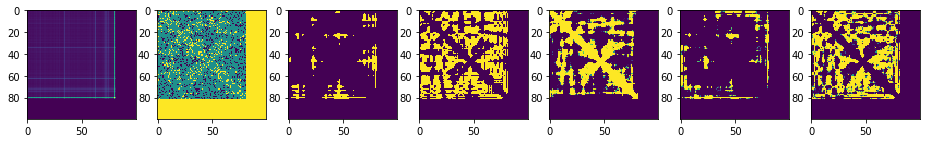

5swd_B


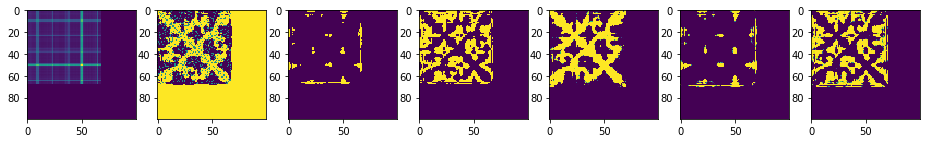

4qlm_A


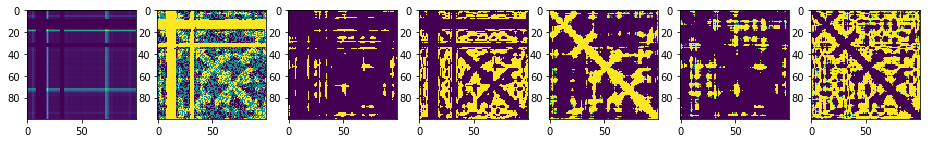

6p2h_A


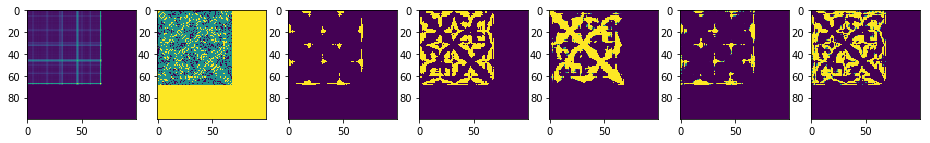

3owz_A


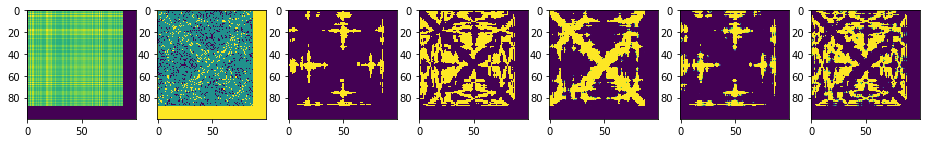

6jq5_B


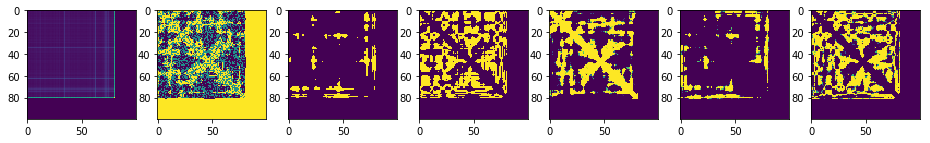

5kpy_A


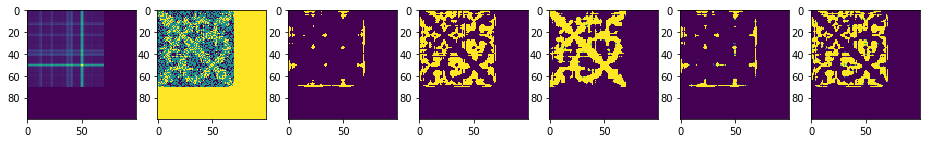

4p9r_A


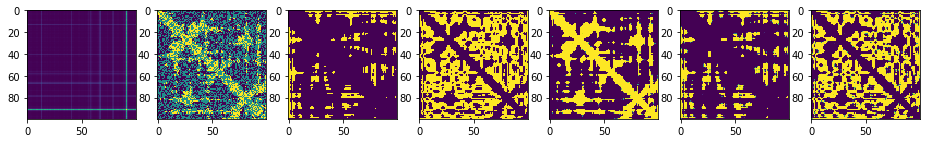

6pmo_B


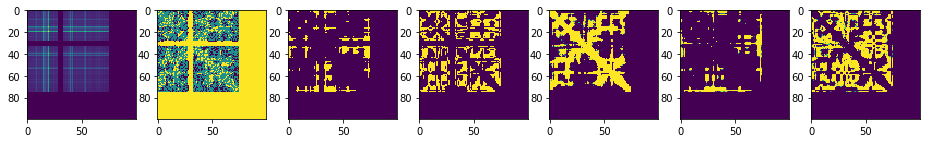

3owz_B


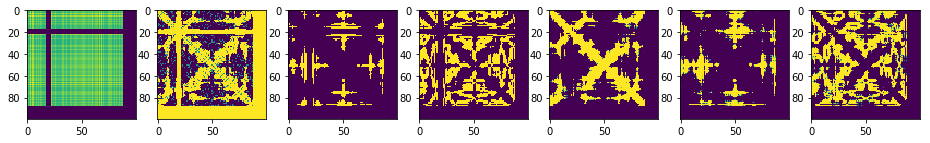

5di4_A


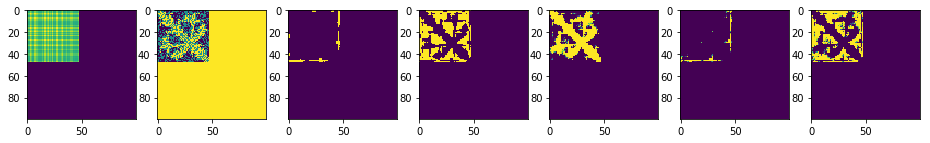

6ol3_C


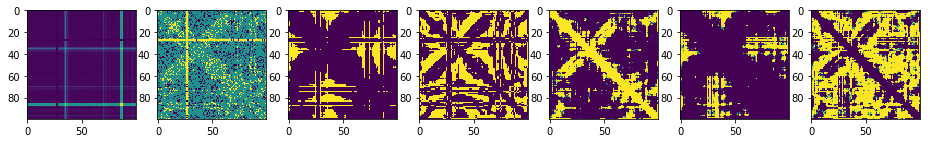

5k7c_B


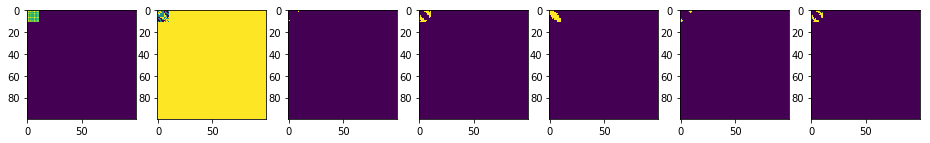

6ufm_B


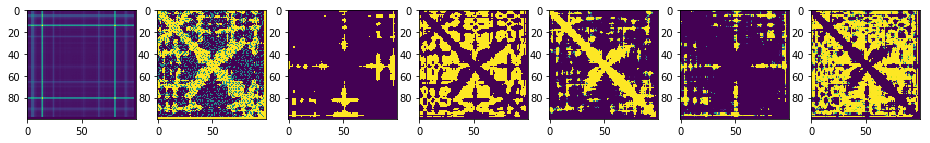

5swd_A


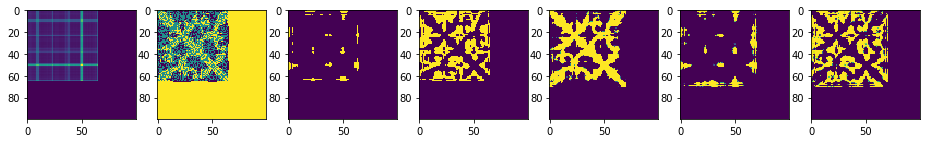

6pmo_A


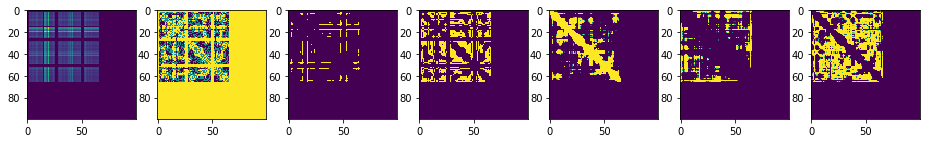

5nwq_A


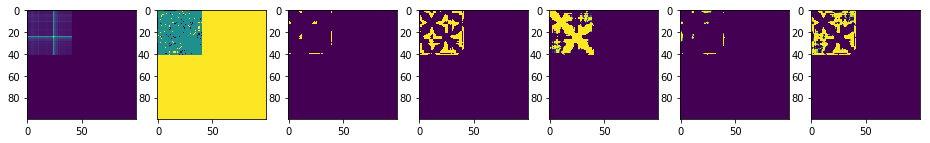

5swe_X


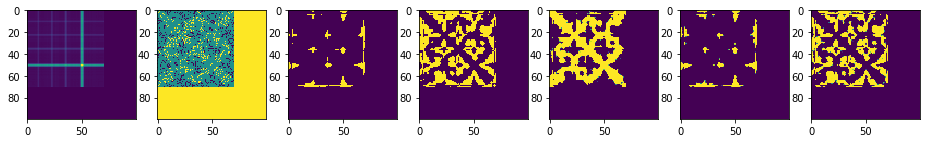

4lck_C


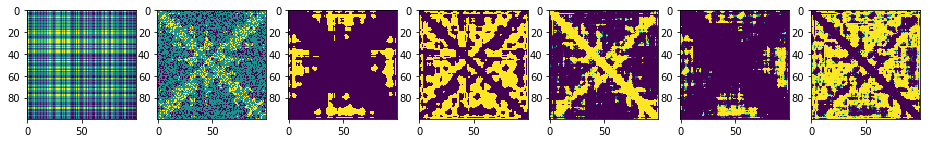

4lck_E


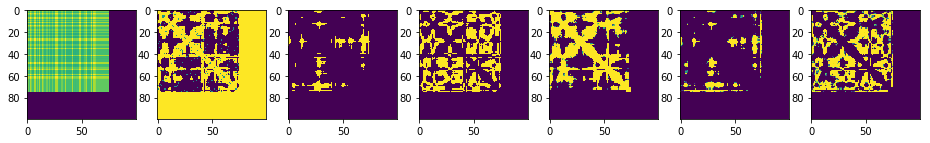

6pom_A


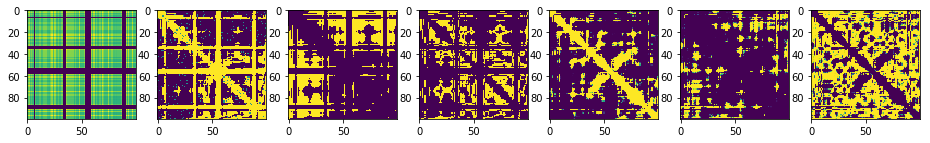

4r4v_A


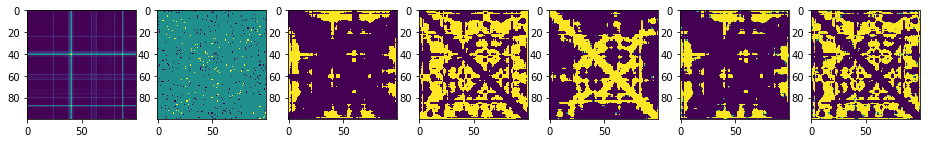

6pom_B


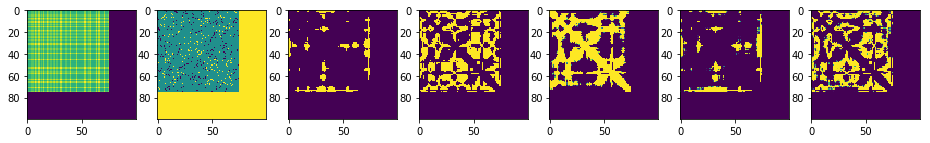

4lck_B


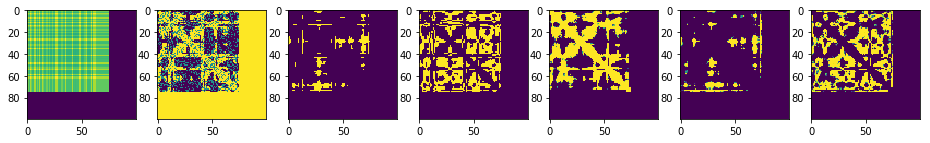

5lyu_A


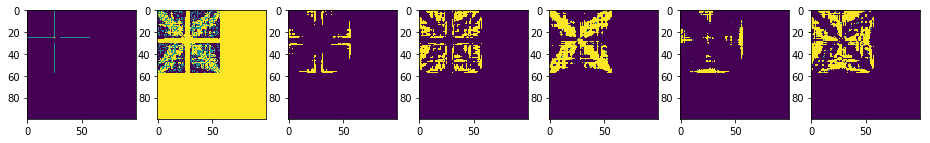

4l81_A


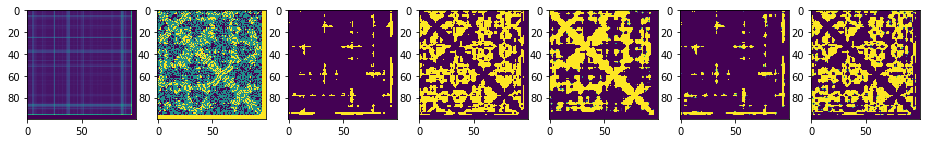

5y85_A


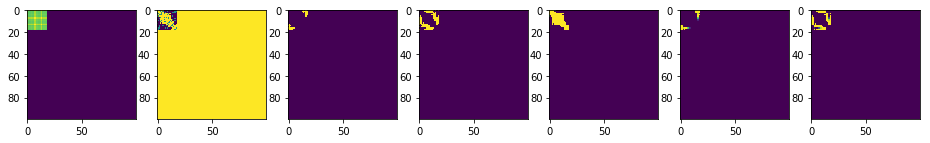

1y26_X


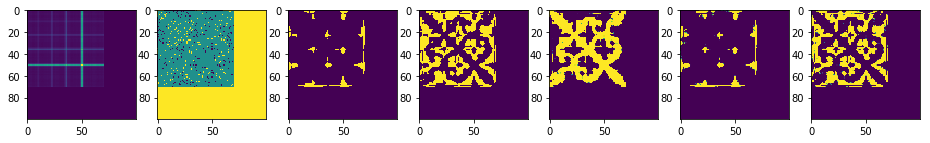

4xw7_A


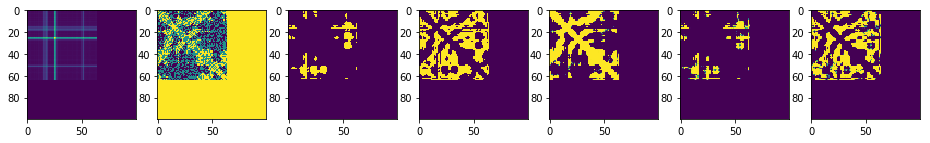

5y85_D


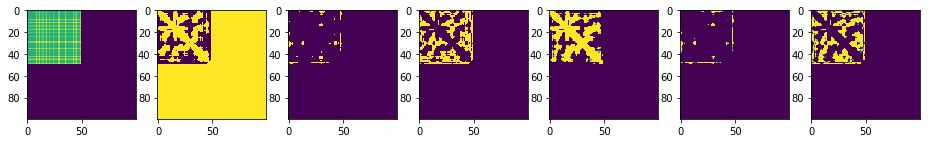

5nwq_B


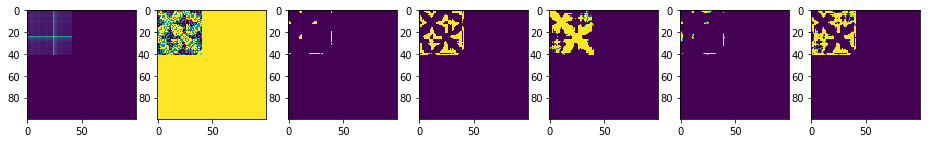

5y85_B


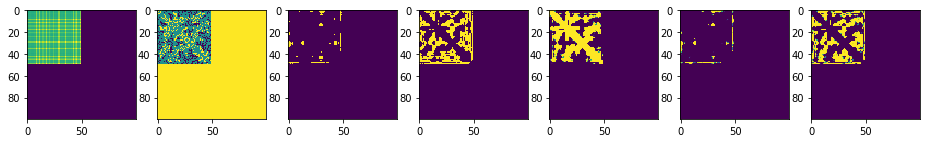

5lyu_B


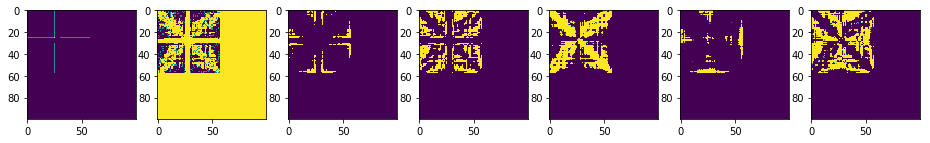

5k7c_A


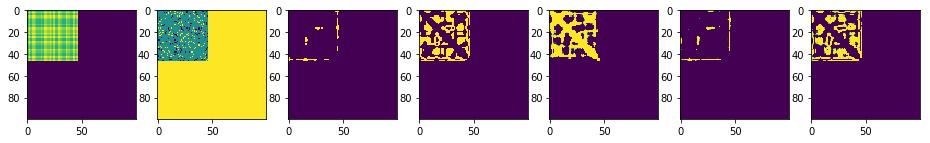

6ufm_A


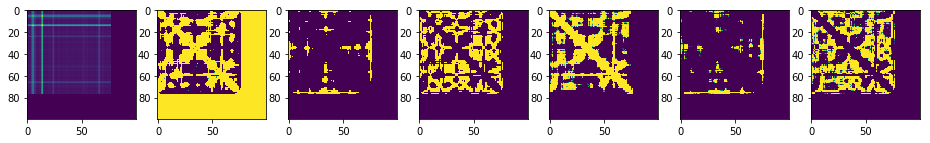

5di4_B


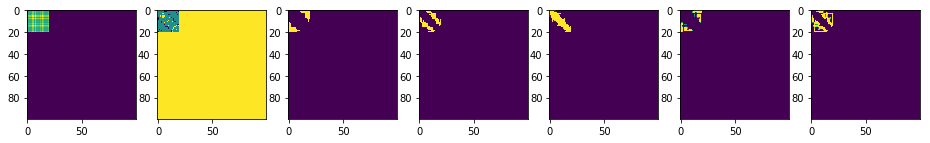

5y85_C


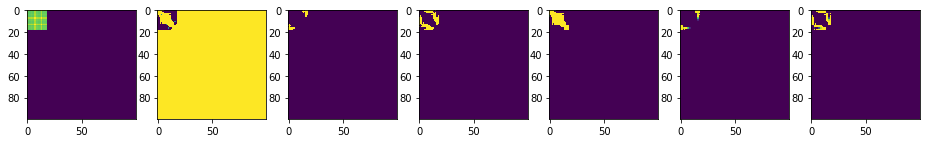

4lck_F


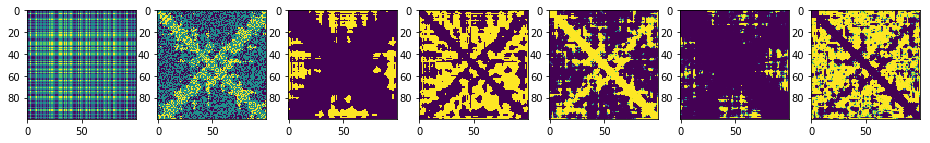

5tpy_A


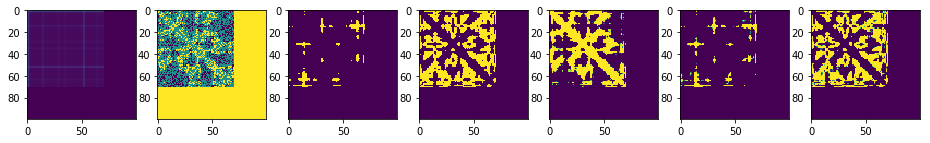

In [27]:
for idx, pdbid in enumerate(tbatch[-1]):
    print(pdbid)
    fig, axs = plt.subplots(1, 7, figsize=(16,8))

    axs[0].imshow(att[idx,0,:,:])
    axs[1].imshow(cmm[idx,0,:,:])
    axs[2].imshow(cmx[idx,:,:,1])
    axs[3].imshow(cmx[idx,:,:,2])
    axs[4].imshow(lmx[idx,:,:,0])
    axs[5].imshow(lmx[idx,:,:,1])
    axs[6].imshow(lmx[idx,:,:,2])
    plt.show()

4p9r_A


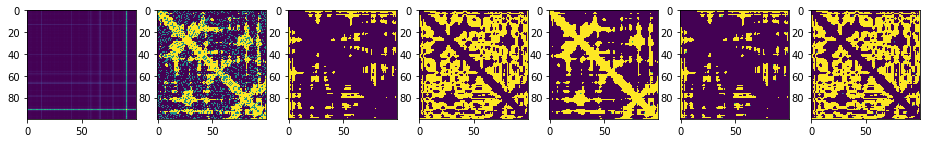

5lyu_B


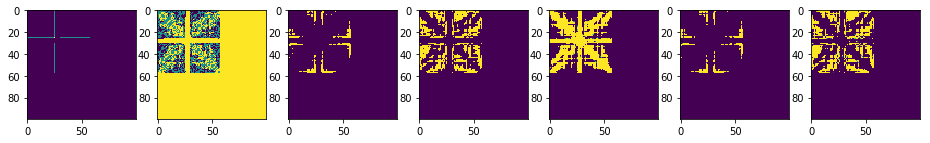

5k7c_A


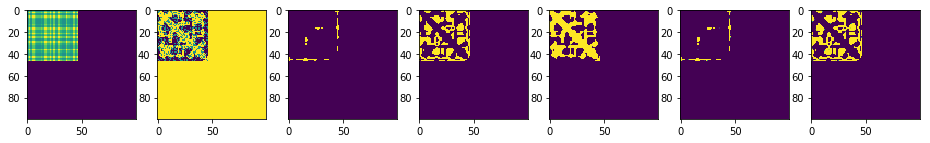

4l81_A


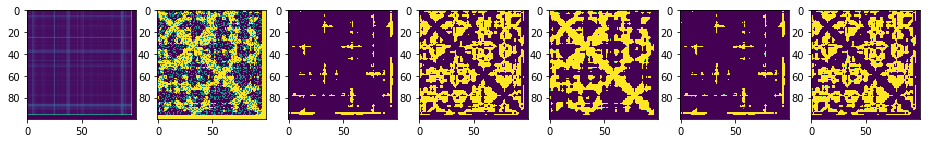

5y85_D


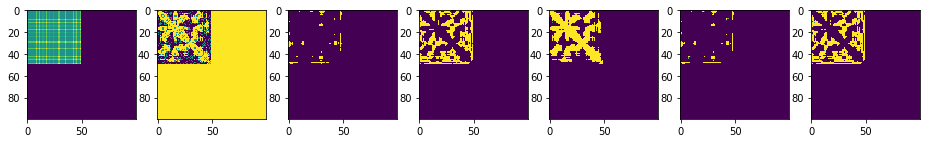

5nwq_A


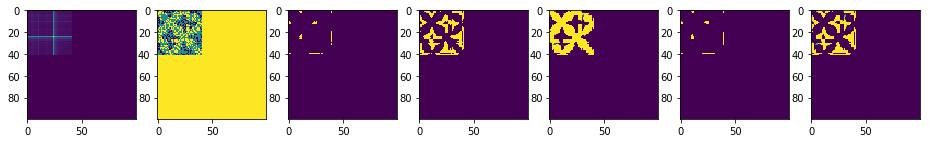

6ufm_A


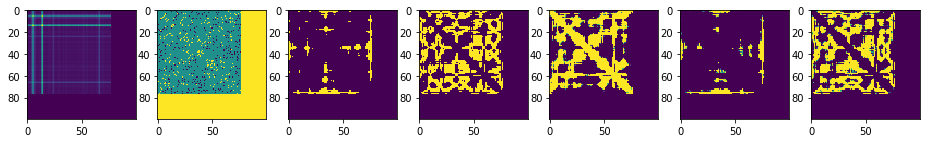

4lck_B


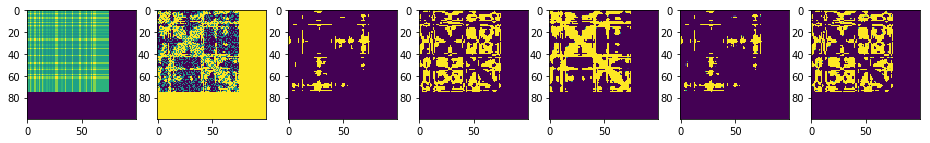

6pmo_A


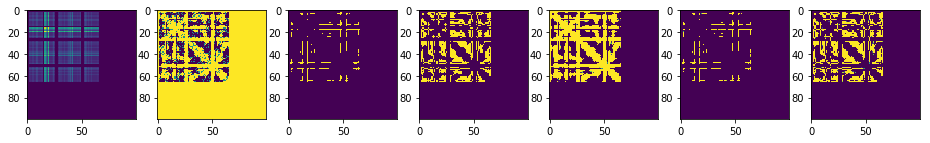

5nwq_B


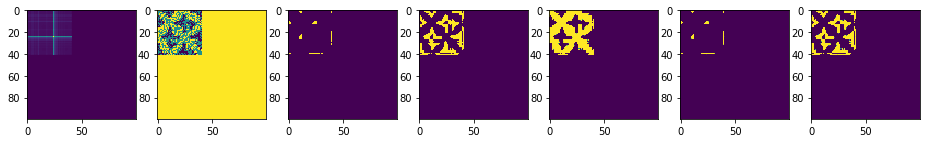

6p2h_A


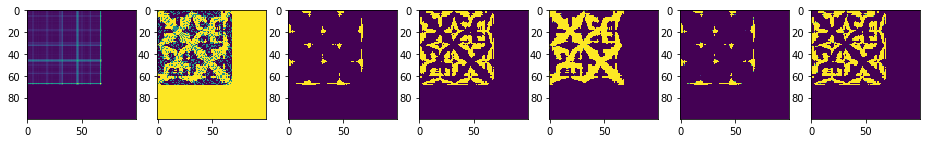

4lck_E


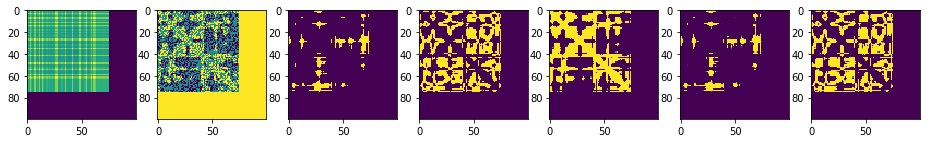

6ol3_C


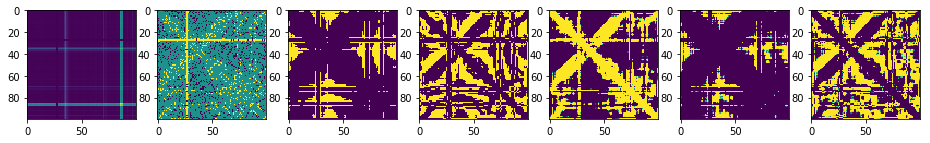

5tpy_A


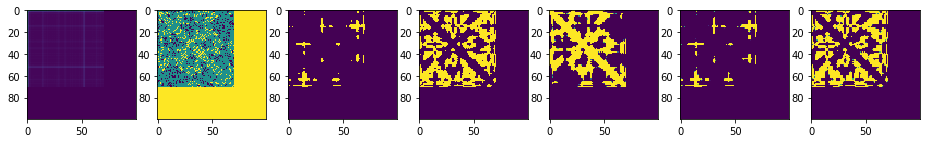

6jq5_A


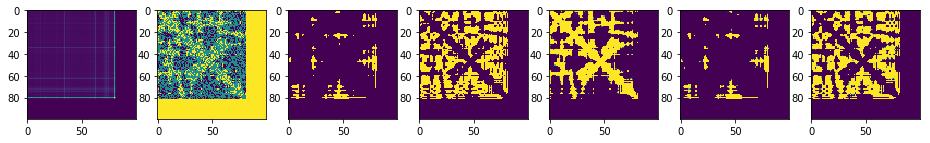

6ufm_B


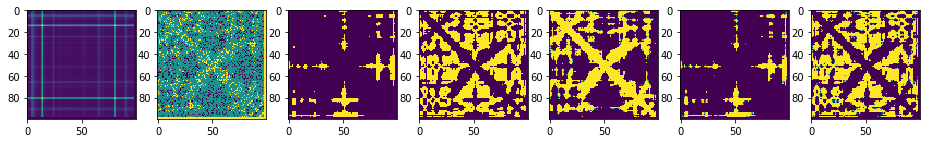

4lck_C


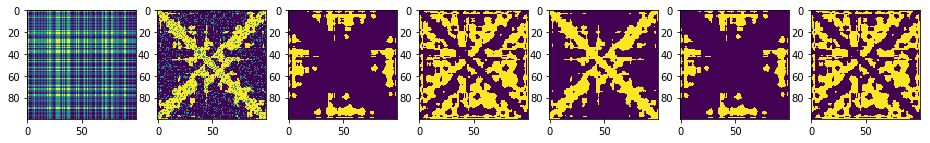

1y26_X


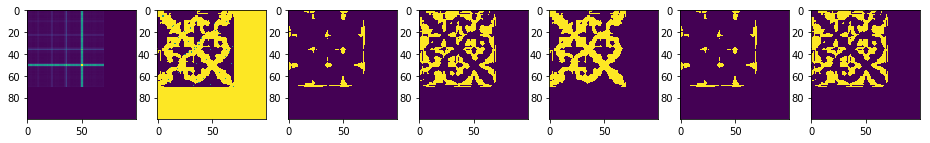

5di4_A


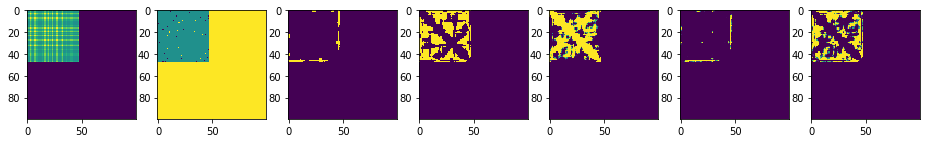

5kpy_A


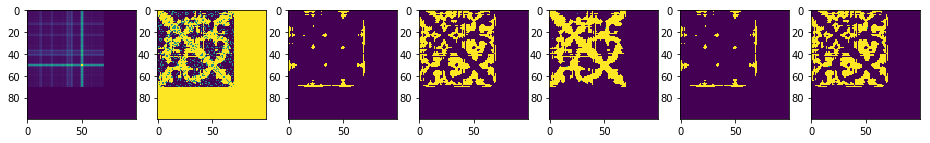

3owz_A


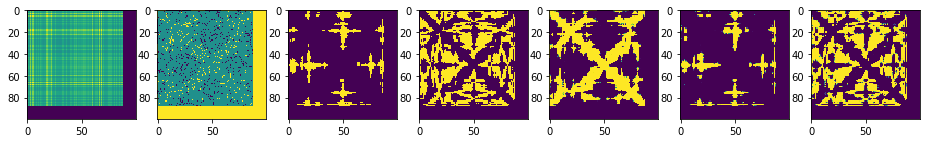

4xw7_A


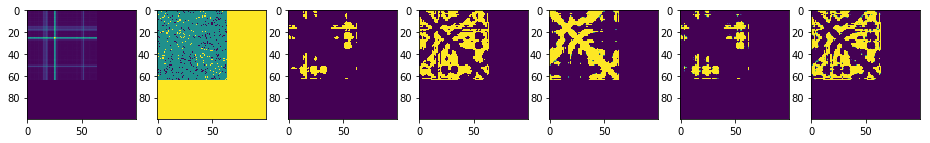

5y85_C


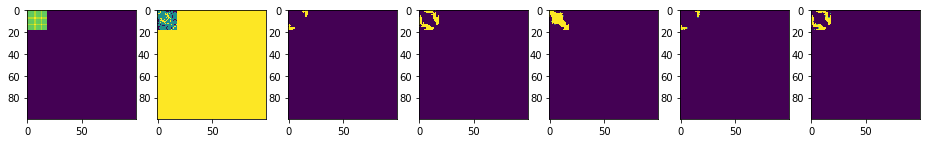

5y85_B


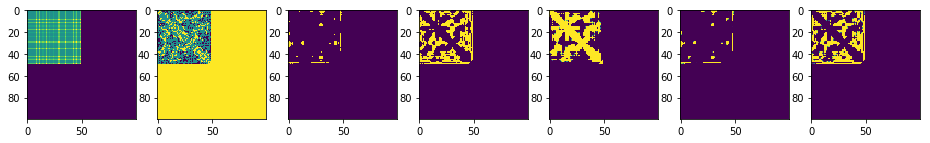

5swd_A


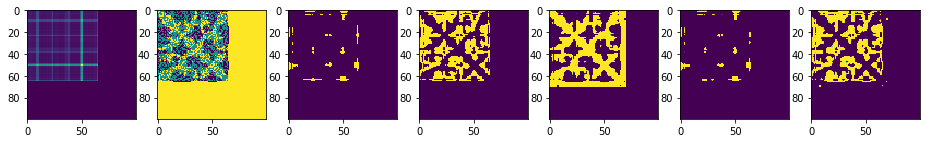

5y85_A


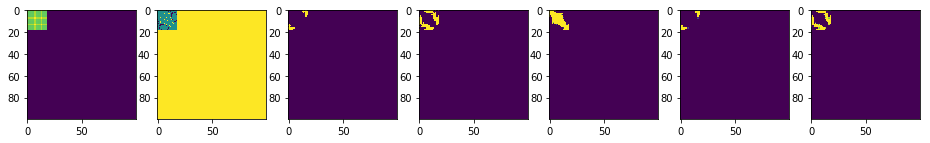

5di4_B


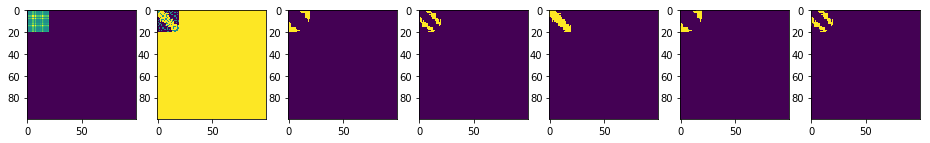

4qlm_A


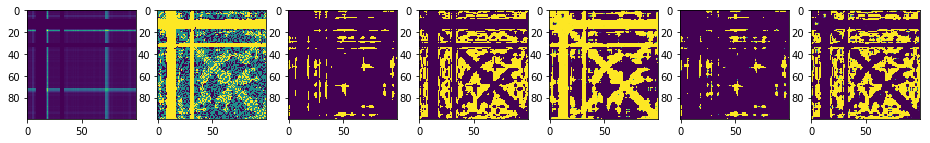

6pmo_B


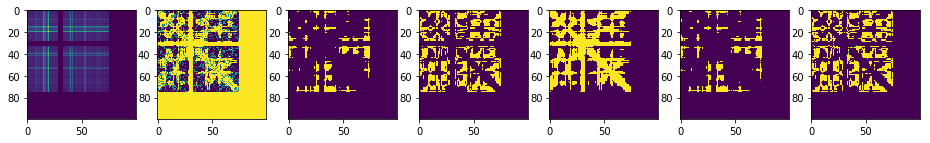

4lck_F


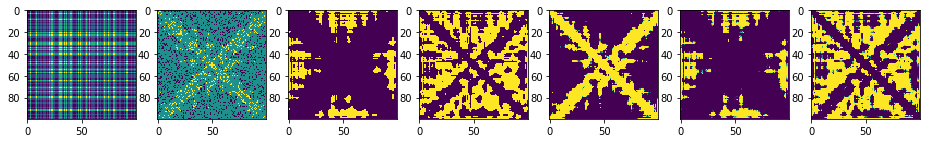

5swd_B


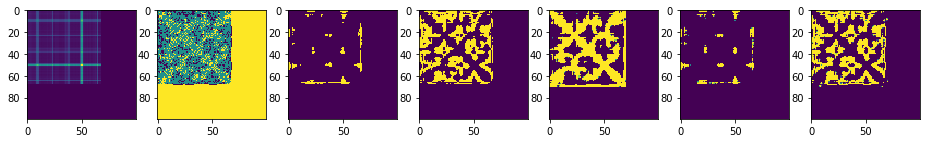

3owz_B


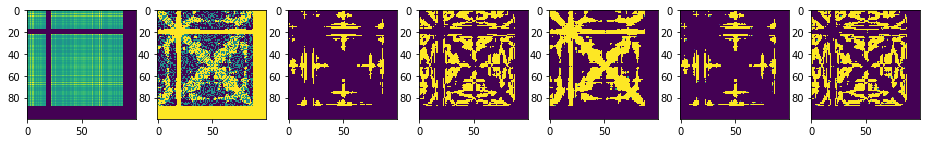

6jq5_B


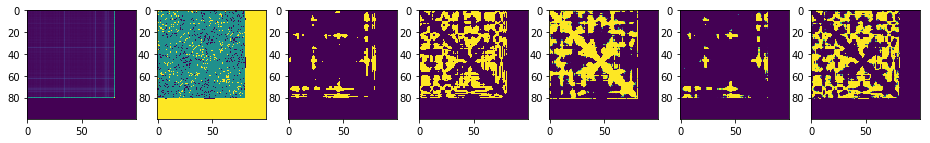

5lyu_A


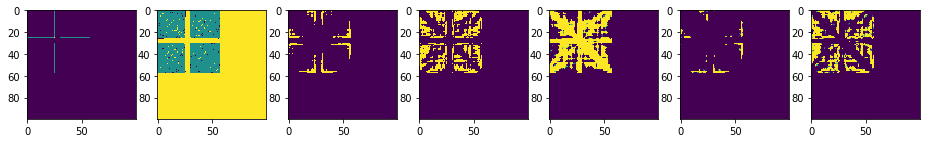

5swe_X


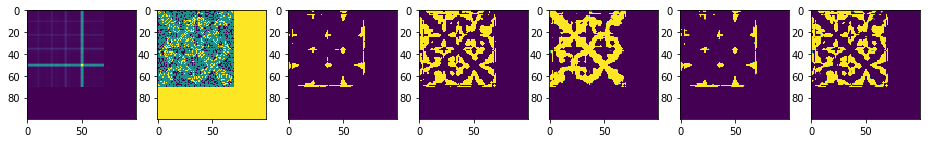

5k7c_B


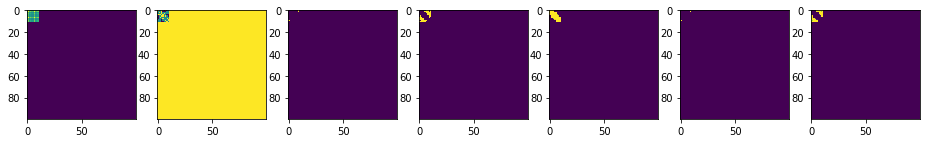

6pom_A


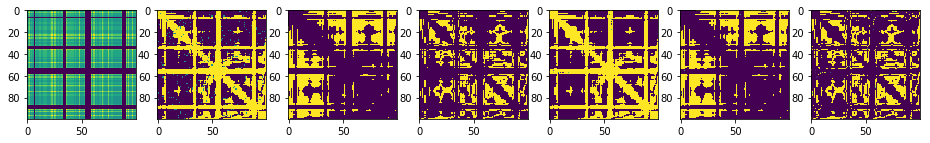

6pom_B


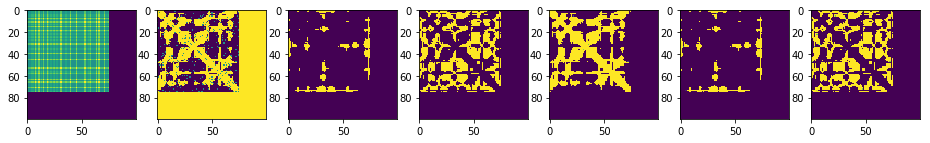

4r4v_A


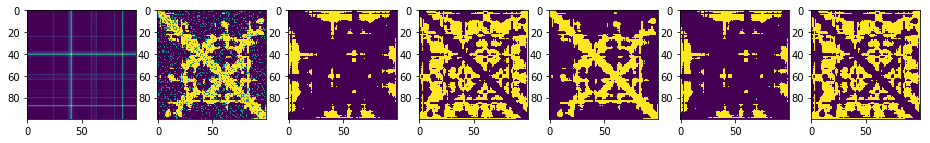

In [19]:
for idx, pdbid in enumerate(tbatch[-1]):
    print(pdbid)
    fig, axs = plt.subplots(1, 7, figsize=(16,8))

    axs[0].imshow(att[idx,0,:,:])
    axs[1].imshow(cmm[idx,0,:,:])
    axs[2].imshow(cmx[idx,:,:,1])
    axs[3].imshow(cmx[idx,:,:,2])
    axs[4].imshow(lmx[idx,:,:,0])
    axs[5].imshow(lmx[idx,:,:,1])
    axs[6].imshow(lmx[idx,:,:,2])
    plt.show()

4lck_F


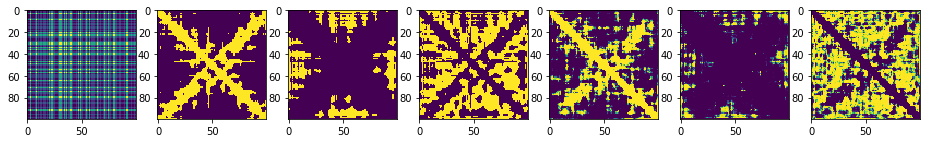

4lck_C


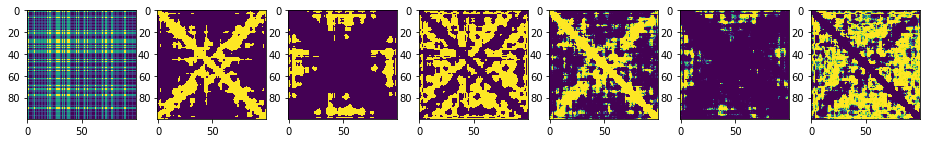

6p2h_A


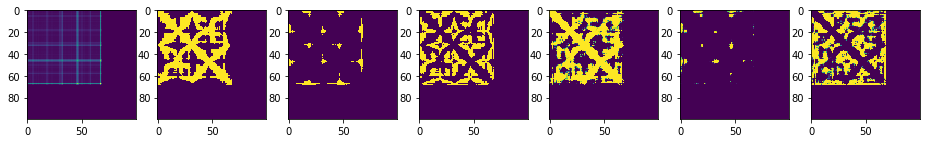

5y85_A


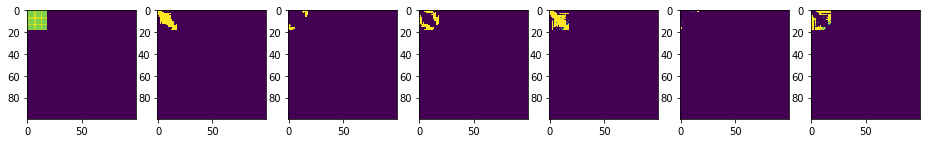

6jq5_A


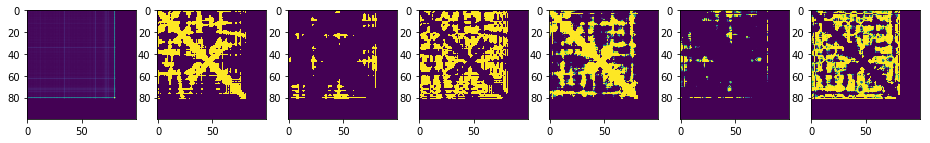

3owz_A


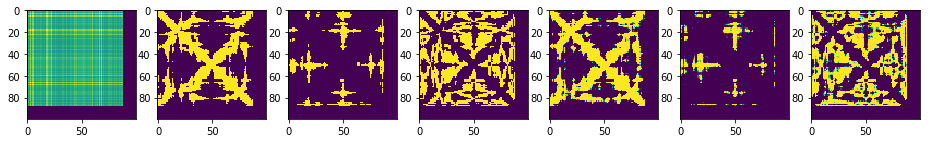

4lck_F


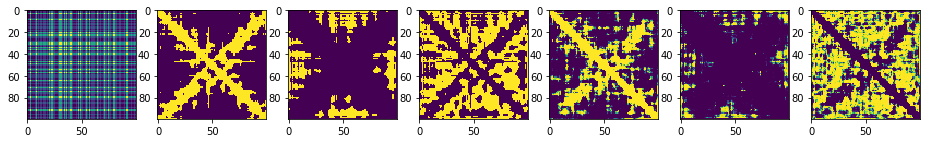

5swd_A


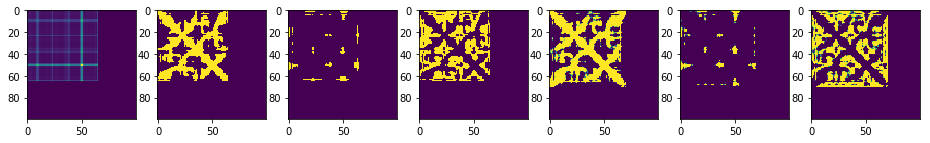

5k7c_B


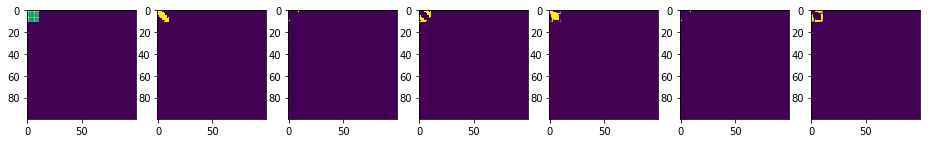

1y26_X


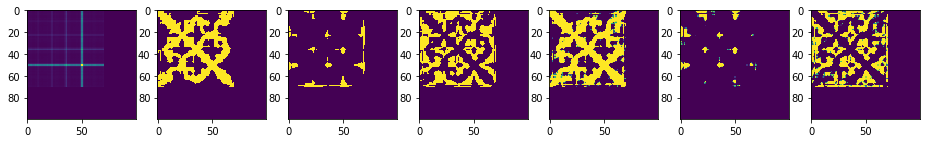

4xw7_A


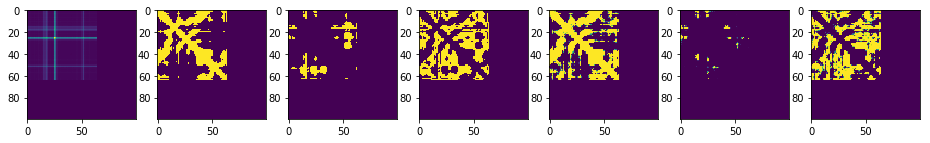

5di4_B


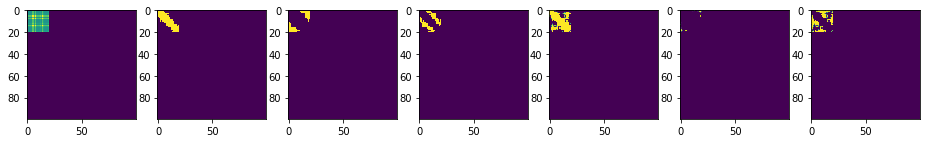

4lck_B


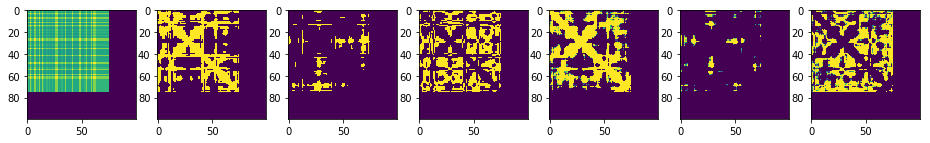

5lyu_B


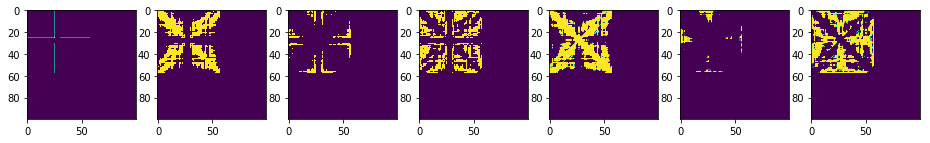

6pmo_B


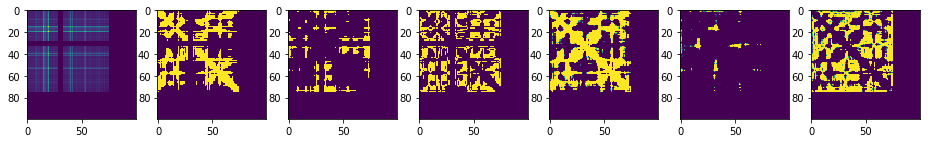

5swe_X


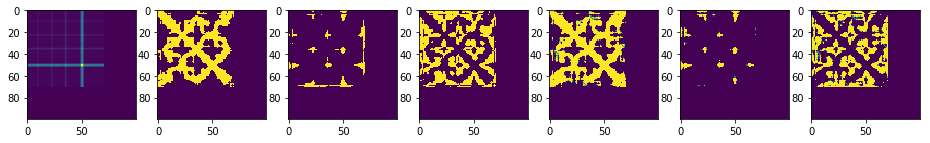

5swd_A


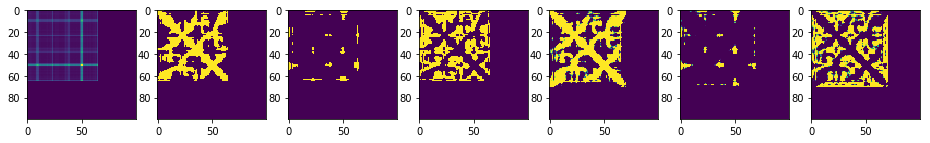

5nwq_B


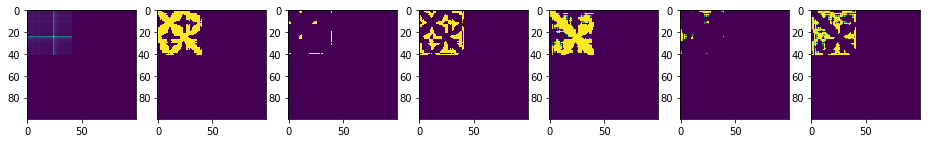

5kpy_A


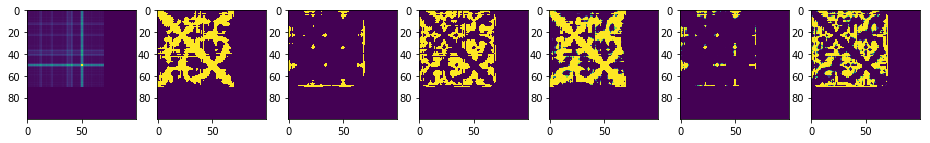

6pom_A


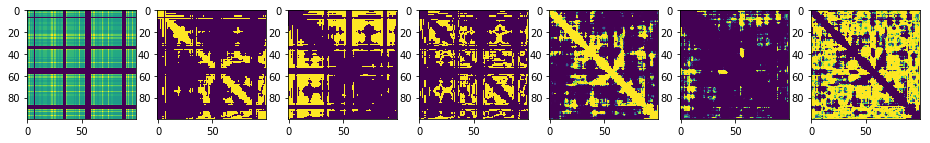

4lck_E


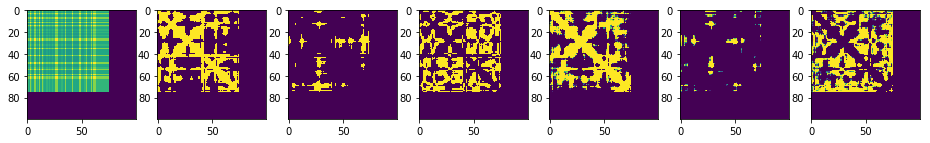

5lyu_A


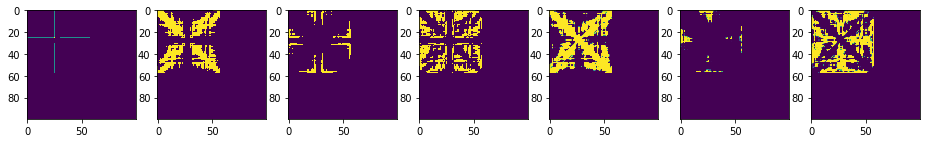

4p9r_A


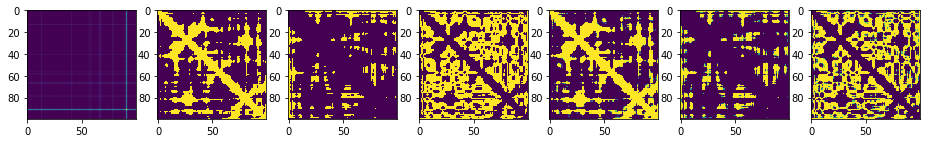

6pom_B


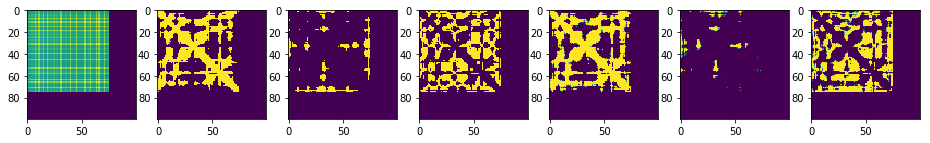

6jq5_B


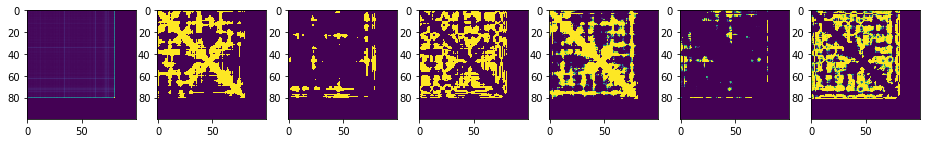

5y85_D


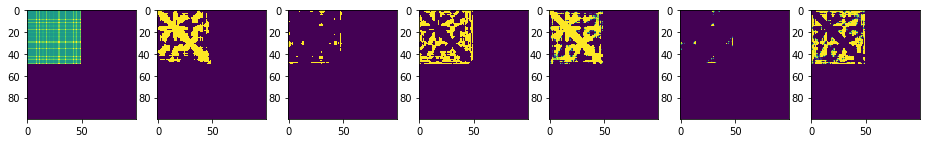

4lck_E


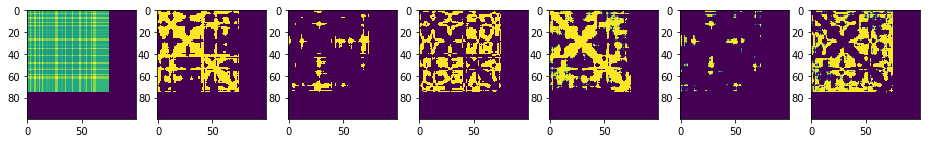

5nwq_B


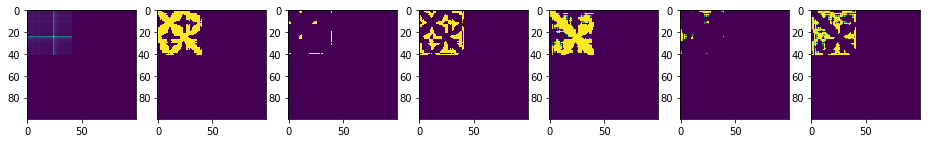

5swd_B


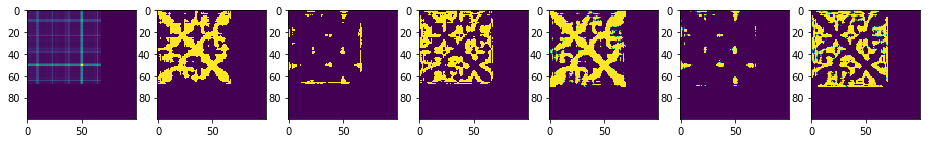

6jq5_B


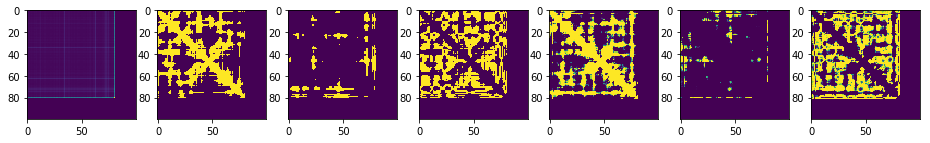

5y85_B


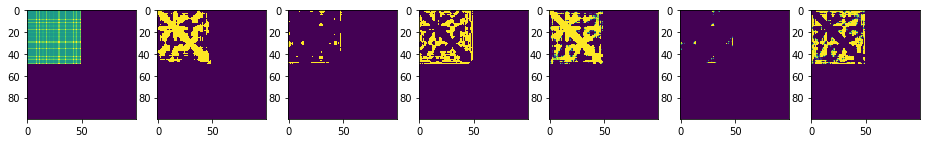

4lck_C


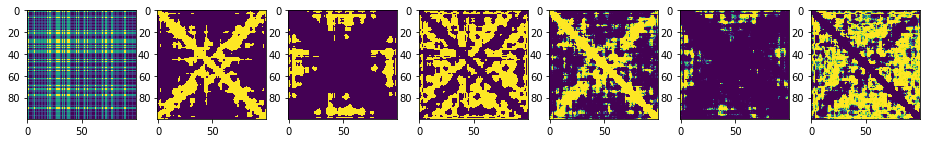

4l81_A


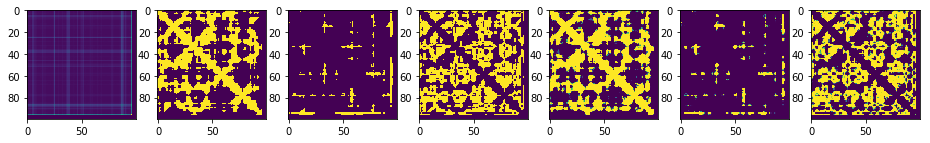

5di4_A


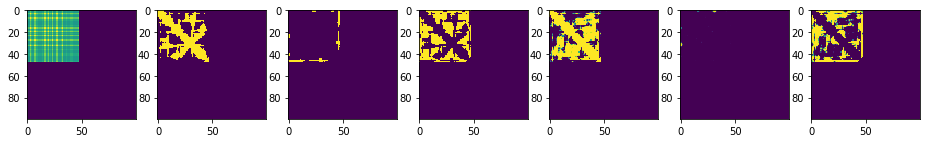

5lyu_A


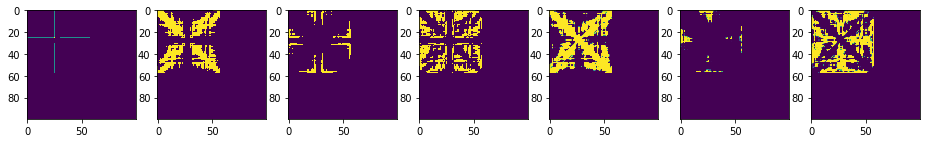

5y85_C


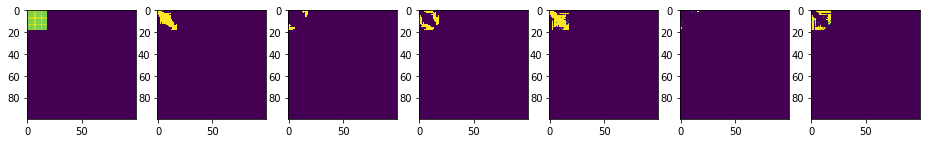

6jq5_B


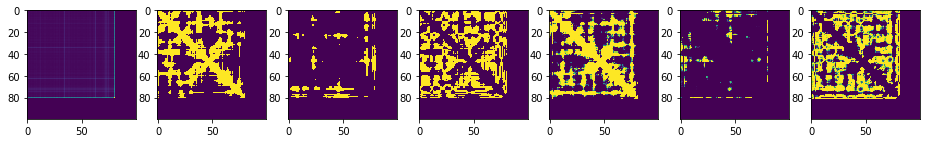

6ufm_A


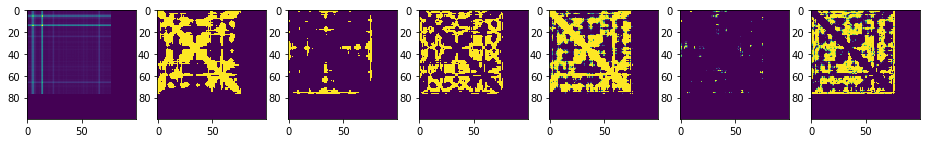

6jq5_B


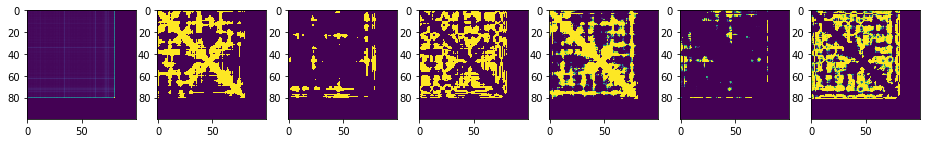

5nwq_B


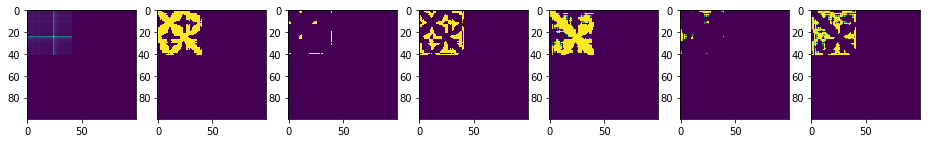

4lck_E


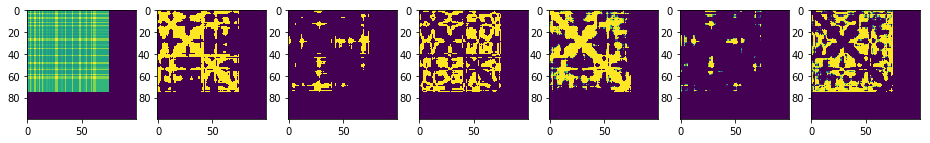

4lck_B


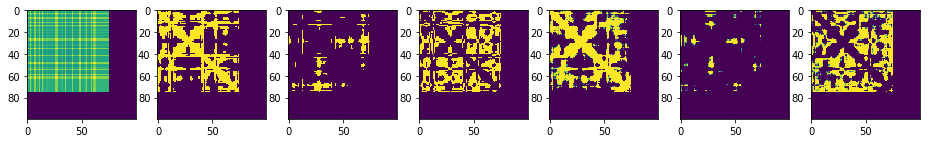

4xw7_A


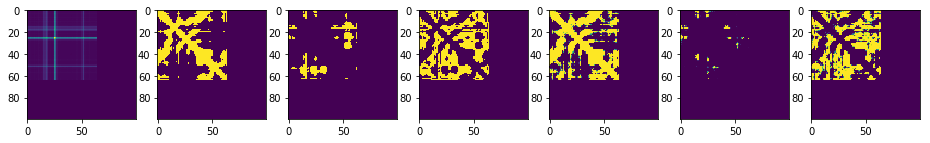

1y26_X


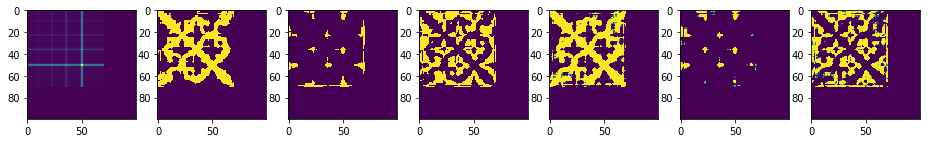

6pmo_B


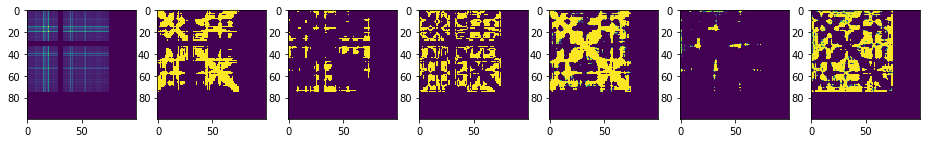

4lck_C


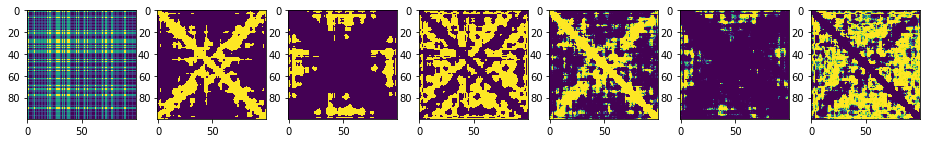

4lck_E


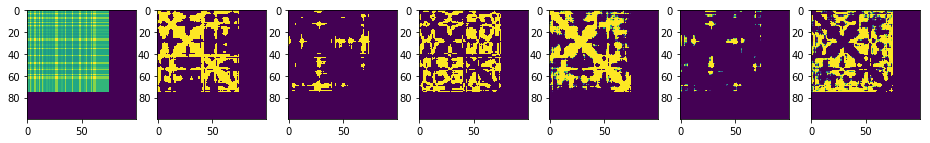

6ufm_B


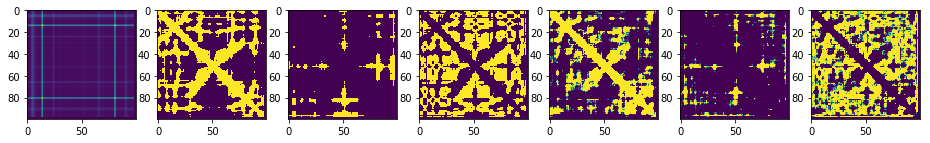

4p9r_A


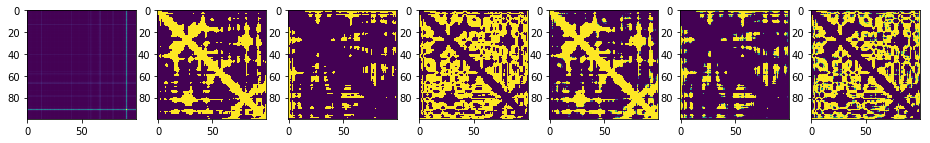

6jq5_A


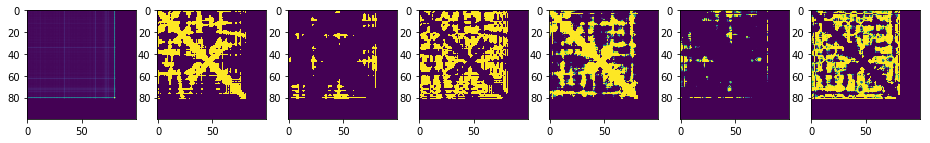

In [103]:
for idx, pdbid in enumerate(tbatch[-1]):
    print(pdbid)
    fig, axs = plt.subplots(1, 7, figsize=(16,8))

    axs[0].imshow(att[idx,0,:,:])
    axs[1].imshow(cmx[idx,:,:,0])
    axs[2].imshow(cmx[idx,:,:,1])
    axs[3].imshow(cmx[idx,:,:,2])
    axs[4].imshow(lmx[idx,:,:,0])
    axs[5].imshow(lmx[idx,:,:,1])
    axs[6].imshow(lmx[idx,:,:,2])
    plt.show()

In [14]:
!cp /gpfs/scratch/ramakers/generator/ckpt/att4_105000.ckpt .

cp: der Aufruf von stat für „/gpfs/scratch/ramakers/generator/ckpt/att4_105000.ckpt“ ist nicht möglich: Datei oder Verzeichnis nicht gefunden


In [17]:
!ls /gpfs/scratch/ramakers/generator/ckpt/att*

/gpfs/scratch/ramakers/generator/ckpt/att_0.ckpt.data-00000-of-00001
/gpfs/scratch/ramakers/generator/ckpt/att_0.ckpt.index
/gpfs/scratch/ramakers/generator/ckpt/att_0.ckpt.meta
/gpfs/scratch/ramakers/generator/ckpt/att_10000.ckpt.data-00000-of-00001
/gpfs/scratch/ramakers/generator/ckpt/att_10000.ckpt.index
/gpfs/scratch/ramakers/generator/ckpt/att_10000.ckpt.meta
/gpfs/scratch/ramakers/generator/ckpt/att_1000.ckpt.data-00000-of-00001
/gpfs/scratch/ramakers/generator/ckpt/att_1000.ckpt.index
/gpfs/scratch/ramakers/generator/ckpt/att_1000.ckpt.meta
/gpfs/scratch/ramakers/generator/ckpt/att_100.ckpt.data-00000-of-00001
/gpfs/scratch/ramakers/generator/ckpt/att_100.ckpt.index
/gpfs/scratch/ramakers/generator/ckpt/att_100.ckpt.meta
/gpfs/scratch/ramakers/generator/ckpt/att_1100.ckpt.data-00000-of-00001
/gpfs/scratch/ramakers/generator/ckpt/att_1100.ckpt.index
/gpfs/scratch/ramakers/generator/ckpt/att_1100.ckpt.meta
/gpfs/scratch/ramakers/generator/ckpt/att_1200.ckpt.data-00000-of-00001
/g

In [ ]:

iter: 0, loss: 8684.63, lr: 0.000000, time_diff: 130.494024
iter: 100, loss: 8793.89, lr: 0.000001, time_diff: 62.351418
iter: 200, loss: 7500.54, lr: 0.000002, time_diff: 38.362012
iter: 300, loss: 6977.70, lr: 0.000003, time_diff: 38.337987
iter: 400, loss: 7174.67, lr: 0.000004, time_diff: 38.610950
iter: 0, loss: 8173.00, lr: 0.000000, time_diff: 123.549179
iter: 0, loss: 8159.94, lr: 0.000000, time_diff: 107.618179
iter: 5000, loss: 4563.56, lr: 0.000500, time_diff: 2878.394060

In [ ]:

iter: 0, loss: 7514.53, lr: 0.000000, time_diff: 117.561431
iter: 100, loss: 7652.73, lr: 0.000001, time_diff: 66.291244
iter: 200, loss: 7312.16, lr: 0.000002, time_diff: 38.649261
iter: 300, loss: 7043.92, lr: 0.000003, time_diff: 38.059663
iter: 400, loss: 6414.52, lr: 0.000004, time_diff: 37.692240
iter: 500, loss: 6627.60, lr: 0.000005, time_diff: 38.033530
iter: 600, loss: 6215.59, lr: 0.000006, time_diff: 38.101918
iter: 700, loss: 5950.66, lr: 0.000007, time_diff: 37.971423
iter: 800, loss: 6202.75, lr: 0.000008, time_diff: 38.147892
iter: 900, loss: 6277.10, lr: 0.000009, time_diff: 37.964864
iter: 1000, loss: 5955.02, lr: 0.000010, time_diff: 38.092577
iter: 1100, loss: 6152.20, lr: 0.000011, time_diff: 38.350446
iter: 1200, loss: 5803.95, lr: 0.000012, time_diff: 38.003059
iter: 1300, loss: 5964.21, lr: 0.000013, time_diff: 37.924385
iter: 1400, loss: 5941.27, lr: 0.000014, time_diff: 37.716707
iter: 1500, loss: 5770.50, lr: 0.000015, time_diff: 38.025988
iter: 1600, loss: 5542.18, lr: 0.000016, time_diff: 38.112454
iter: 1700, loss: 5377.47, lr: 0.000017, time_diff: 38.029388
iter: 1800, loss: 5566.15, lr: 0.000018, time_diff: 38.431313
iter: 1900, loss: 5524.18, lr: 0.000019, time_diff: 38.104070
iter: 2000, loss: 5991.37, lr: 0.000020, time_diff: 38.135458
iter: 2100, loss: 5851.18, lr: 0.000021, time_diff: 37.842860
iter: 2200, loss: 5503.19, lr: 0.000022, time_diff: 38.064893
iter: 2300, loss: 5657.90, lr: 0.000023, time_diff: 37.873489
iter: 2400, loss: 5465.32, lr: 0.000024, time_diff: 38.155061
iter: 2500, loss: 5618.63, lr: 0.000025, time_diff: 37.861090
iter: 2600, loss: 5534.90, lr: 0.000026, time_diff: 38.281447
iter: 2700, loss: 5848.69, lr: 0.000027, time_diff: 38.338524
iter: 2800, loss: 5597.07, lr: 0.000028, time_diff: 38.047816
iter: 2900, loss: 5816.53, lr: 0.000029, time_diff: 37.956980
iter: 3000, loss: 5974.62, lr: 0.000030, time_diff: 38.237218
iter: 3100, loss: 6166.09, lr: 0.000031, time_diff: 37.996356
iter: 3200, loss: 5626.02, lr: 0.000032, time_diff: 38.208416
iter: 3300, loss: 5543.37, lr: 0.000033, time_diff: 38.176072
iter: 3400, loss: 5658.27, lr: 0.000034, time_diff: 37.816941
iter: 3500, loss: 5730.02, lr: 0.000035, time_diff: 38.197093
iter: 3600, loss: 5378.97, lr: 0.000036, time_diff: 38.006978
iter: 3700, loss: 5845.07, lr: 0.000037, time_diff: 37.975427
iter: 3800, loss: 5499.49, lr: 0.000038, time_diff: 37.823282
iter: 3900, loss: 5574.90, lr: 0.000039, time_diff: 37.885856
iter: 4000, loss: 5531.64, lr: 0.000040, time_diff: 38.317242
iter: 4100, loss: 5313.17, lr: 0.000041, time_diff: 38.154846
iter: 4200, loss: 5642.43, lr: 0.000042, time_diff: 38.429988
iter: 4300, loss: 5514.75, lr: 0.000043, time_diff: 38.457540
iter: 4400, loss: 5447.11, lr: 0.000044, time_diff: 38.566615
iter: 4500, loss: 5397.92, lr: 0.000045, time_diff: 38.355303
iter: 4600, loss: 5780.92, lr: 0.000046, time_diff: 38.287497
iter: 5000, loss: 5617.24, lr: 0.000050, time_diff: 265.371716
iter: 0, loss: 7848.22, lr: 0.000000, time_diff: 85.208670
iter: 5000, loss: 4551.53, lr: 0.000050, time_diff: 2178.938389